In [1]:
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


In [4]:
import random

In [5]:
SIZE_FACE=48
FILE_PATH = 'fer2013.csv'
data = pd.read_csv(FILE_PATH)

In [6]:
img_size=48

In [7]:
data.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
def emotion_labeller(x):
    d = np.zeros(len(EMOTIONS))
    d[x] = 1.0
    return d

In [9]:
# returns pixel 48*48
def image_resizer(data):
    data_image = np.fromstring(str(data), dtype = np.uint8, sep = ' ').reshape((SIZE_FACE, SIZE_FACE))
    
    return data_image

In [10]:
# return image ..
def image_formater(data):
    #print data
    data_image = np.fromstring(str(data), dtype = np.uint8, sep = ' ').reshape((SIZE_FACE, SIZE_FACE))
    data_image = Image.fromarray(data_image).convert('RGB')
    return data_image

In [11]:
labels = []
images = []
pixels=[]
index = 1
total = data.shape[0]
for index,row in data.iterrows():
    emotion = emotion_labeller(row[0])
    pixel = image_resizer(row[1])
    image=image_formater(row[1])
    if image is not None:
        labels.append(emotion)
        images.append(image)
        pixels.append(pixel)

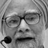

In [12]:
images[1]

In [13]:
size_of_image=np.array(images[0])
size_of_image.shape

(48, 48, 3)

In [14]:
x=np.array(pixels)
x.shape

(35887, 48, 48)

In [15]:
target=data['emotion']

In [16]:
t=[]
for i in range(len(pixels)):
    t.append(x[i].reshape(48*48))


In [17]:
df=pd.DataFrame(t)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,70,80,82,72,58,58,60,63,54,58,...,159,182,183,136,106,116,95,106,109,82
1,151,150,147,155,148,133,111,140,170,174,...,105,108,95,108,102,67,171,193,183,184
2,231,212,156,164,174,138,161,173,182,200,...,104,138,152,122,114,101,97,88,110,152
3,24,32,36,30,32,23,19,20,30,41,...,174,126,132,132,133,136,139,142,143,142
4,4,0,0,0,0,0,0,0,0,0,...,12,34,31,31,31,27,31,30,29,30


In [18]:
df.shape

(35887, 2304)

In [19]:
def split():
    x_train,x_test,y_train,y_test=train_test_split(df,labels,test_size=0.25,random_state=42)
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    return x_train,y_train 

In [20]:
num_classes=7
num_channels=3

In [21]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x

<tf.Tensor 'x:0' shape=(?, 48, 48, 3) dtype=float32>

In [22]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true

<tf.Tensor 'y_true:0' shape=(?, 7) dtype=float32>

In [23]:
def pre_process_image(image, training):
        
    if training:
        
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        image = tf.image.random_flip_left_right(image)        
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [24]:
def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    return images

In [ ]:
distorted_images = pre_process(images=x, training=True)

##  CONVOLUTION NETWORK


In [25]:
n_input = 2304
n_classes = 7
learning_rate = 0.01
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])


In [26]:
weights = {
    'wc1' : tf.Variable(tf.random_normal([5,5, 1, 32])),
    'wc2' : tf.Variable(tf.random_normal([5,5, 32, 64])),
    'whl' : tf.Variable(tf.random_normal([12 *12 * 64, 1024])),
    'out' : tf.Variable(tf.random_normal([1024, n_classes])),
}

biases = {
    'bc1' : tf.Variable(tf.random_normal([32])),
    'bc2' : tf.Variable(tf.random_normal([64])),
    'bhl' : tf.Variable(tf.random_normal([1024])),
    'outB' : tf.Variable(tf.random_normal([n_classes])),
}

In [27]:
def score(total,count):
    total=total+count
    return total

In [28]:
start_batch=0
def next_batch(num, data, labels):
    global start_batch
    data_shuffle=data[start_batch:start_batch+num]
    labels_shuffle=labels[start_batch:start_batch+num]
    start_batch+=num        
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [31]:
def random_batch():
    num_images = len(images_train)
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    x_batch = images_train[idx, :, :,:]
    y_batch = labels_train[idx, :]
    return x_batch, y_batch

In [32]:
def conv(x, w, b, strides=1):
    x = tf.nn.conv2d(x, w, padding='SAME', strides=[1,strides, strides,1])
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpooling(x, k = 2):
    return tf.nn.max_pool(x, padding='SAME', ksize=[1, k, k, 1], strides=[1,k, k, 1])
    
def cnn_result(x, weights, biases) :
    x = tf.reshape(x, shape=[-1, 48, 48, 1])
    conv1 = conv(x, weights['wc1'], biases['bc1'])
    conv1 = maxpooling(conv1, k = 2)
    
    conv2 = conv(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpooling(conv2, k = 2)
    
    hidden_input = tf.reshape(conv2, [-1, 12 * 12 * 64])
    hidden_output_before_relu = tf.add(tf.matmul(hidden_input, weights['whl']), biases['bhl'])
    hidden_output = tf.nn.relu(hidden_output_before_relu)
    
    out = tf.add(tf.matmul(hidden_output, weights['out']), biases['outB'])
    return out

In [33]:
pred = cnn_result(x, weights, biases)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


In [35]:
count = 0
var=0
init = tf.global_variables_initializer()
batch_size = 100
sess = tf.Session()
sess.run(init)
t0=time()
for i in range(15):
    num_batches = 269
    total_cost = 0
    total = 0
    x_train,y_train=split()
    var=random.uniform(1.5,3.5)
    count+=var
    start_batch=0
    for j in range(num_batches):
        batch_x, batch_y = next_batch(batch_size,x_train,y_train)
        _,c,cp = sess.run([optimizer,cost,correct_prediction], feed_dict={x: batch_x, y : batch_y})
        cp.sort()
        index=0
        while(1):
            if(cp[index]):
                break
            else:
                index+=1
        
        total +=(len(cp)-index)/len(cp)
        total_cost += c
    cs=score(total,count)
    print('accuracy' , cs/num_batches)
print("done in %0.3fs" % (time() - t0))

accuracy 0.1966543991395967
accuracy 0.23669765333722975
accuracy 0.2554258963798178
accuracy 0.2663519051452248
accuracy 0.2778547250514609
accuracy 0.2854224016212402
accuracy 0.2940374601771568
accuracy 0.30325768228674393
accuracy 0.31063188297518235
accuracy 0.3191693416381969
accuracy 0.32925343115991623
accuracy 0.3395189143269602
accuracy 0.3493771331626525
accuracy 0.35762577078989644
accuracy 0.36516587301719305
done in 4897.862s
